## Why CNN?

### Convolutional Neural Networks (CNNs) are particularly well-suited for image classification tasks because they automatically learn spatial hierarchies of features from input images. In this project, since we are working with simple geometric shapes, CNNs are sufficient and efficient for capturing local patterns such as edges and contours that distinguish circles, squares, and triangles.

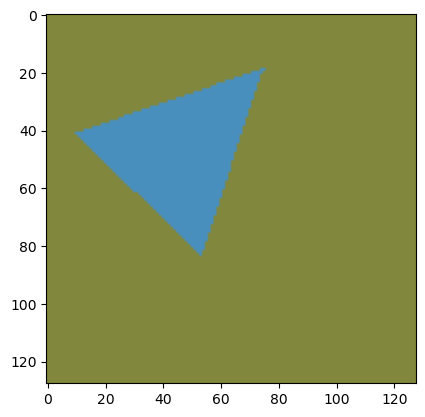

In [1]:
import random
import numpy as np
from PIL import Image, ImageDraw
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math

# Rotation function
def rotate_point(x, y, angle, center):
    """Rotate a point (x, y) around a specified center by a given angle."""
    angle_rad = math.radians(angle)  # Convert angle to radians
    cos_angle = math.cos(angle_rad)
    sin_angle = math.sin(angle_rad)
    
    # Apply the rotation formula
    x_new = cos_angle * (x - center[0]) - sin_angle * (y - center[1]) + center[0]
    y_new = sin_angle * (x - center[0]) + cos_angle * (y - center[1]) + center[1]
    
    return x_new, y_new

# Shape generation function
def generate_shape_image(shape_type, size, rotation_angle, image_size=(128, 128)):
    """
    Generates an image of a specified shape.
    shape_type: 'circle', 'square', 'triangle'
    size: size of the shape
    rotation_angle: rotation angle of the shape
    """
    # Random color for the background
    fill_color = (int(np.random.normal(127, 30)), int(np.random.normal(127, 30)), int(np.random.normal(127, 30)))
    image = Image.new('RGB', image_size, fill_color)  # Background with random color
    draw = ImageDraw.Draw(image)
    shape_center = (np.random.normal(image_size[0], 30) // 2, np.random.normal(image_size[1], 30) // 2)  # Center of the shape

    if shape_type == 'circle':
        bbox = [shape_center[0] - size // 2, shape_center[1] - size // 2, shape_center[0] + size // 2, shape_center[1] + size // 2]
        draw.ellipse(bbox, fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))  # Random color circle
    elif shape_type == 'square':
        bbox = [shape_center[0] - size // 2, shape_center[1] - size // 2, shape_center[0] + size // 2, shape_center[1] + size // 2]
        draw.rectangle(bbox, fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))  # Random color square
    elif shape_type == 'triangle':
        triangle_points = [(shape_center[0], shape_center[1] - size // 2), 
                           (shape_center[0] - size // 2, shape_center[1] + size // 2), 
                           (shape_center[0] + size // 2, shape_center[1] + size // 2)]
        rotated_triangle_points = [rotate_point(x, y, rotation_angle, shape_center) for (x, y) in triangle_points]
        # Draw the rotated triangle
        draw.polygon(rotated_triangle_points, fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))  # Random color triangle

    return image

# Test the image generation
image = generate_shape_image('triangle', 60, 45)
plt.imshow(image)
plt.show()


In [2]:
def generate_dataset(num_samples=1000, image_size=(128, 128)):
    shapes = ['circle', 'square', 'triangle']
    dataset = []
    labels = []

    for _ in range(num_samples):
        shape = random.choice(shapes)
        
        # Randomly select conditions
        condition = random.choice(['fixed_length_fixed_rotation', 'fixed_length_random_rotation', 
                                   'random_length_fixed_rotation', 'random_length_random_rotation'])

        if condition == 'fixed_length_fixed_rotation':
            size = 60
            rotation_angle = 0
        elif condition == 'fixed_length_random_rotation':
            size = 60
            rotation_angle = random.randint(0, 360)
        elif condition == 'random_length_fixed_rotation':
            size = random.randint(30, 80)
            rotation_angle = 0
        elif condition == 'random_length_random_rotation':
            size = random.randint(30, 80)
            rotation_angle = random.randint(0, 360)

        # Generate image
        image = generate_shape_image(shape, size, rotation_angle, image_size)
        dataset.append(np.array(image))
        labels.append(shapes.index(shape))  # 0: Circle, 1: Square, 2: Triangle

    return np.array(dataset), np.array(labels)

# Generate dataset
x, y = generate_dataset(num_samples=1000)


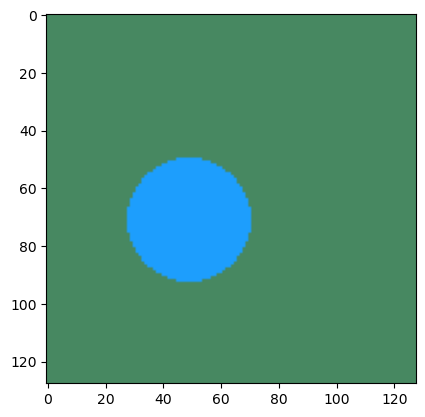

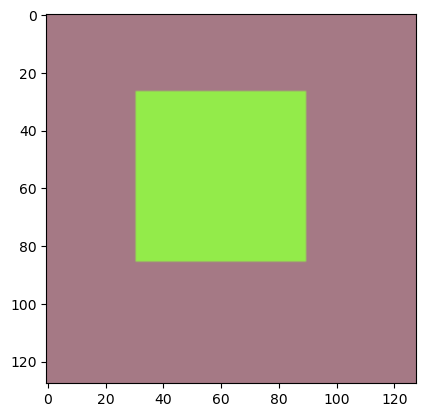

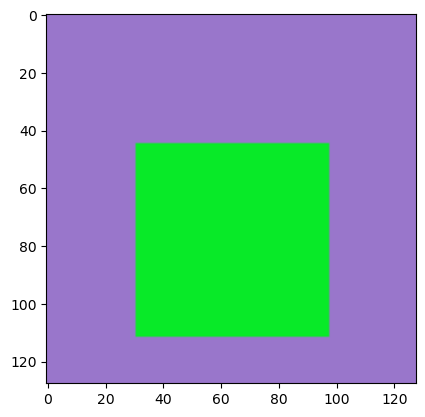

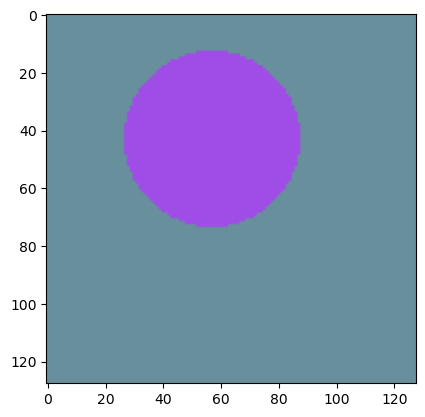

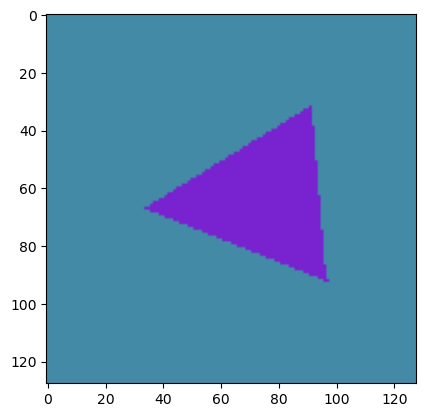

In [3]:
for i in range(5):
    plt.imshow(Image.fromarray(x[i]))
    plt.show()

In [4]:
class ShapeDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PIL image
        image = Image.fromarray(image)

        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformation: Convert from numpy to Tensor and apply normalization
transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create training, validation, and test sets
dataset = ShapeDataset(x, y, transform=transform)

# Split dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
import torch.nn as nn
class ShapeClassifierCNN(nn.Module):
    def __init__(self):
        super(ShapeClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Assuming image size is 128x128
        self.dropout = nn.Dropout(p=0.5)  # Dropout applied here
        self.fc2 = nn.Linear(512, 3)      # Three output classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)  # 64x64
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  # 32x32
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)  # 16x16
        x = x.view(x.size(0), -1)   # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)         # Apply dropout here
        x = self.fc2(x)
        return x

## Training Configuration Rationale:

### Optimizer: Adam optimizer was chosen for its adaptive learning rate capabilities and good default settings for most vision tasks.

### Scheduler: StepLR reduces the learning rate after every 5 epochs, which helps the model converge smoothly.

### Early Stopping: Used to prevent overfitting by halting training if the validation accuracy stops improving after several epochs.

Epoch 1/50, Train Loss: 1.1196, Train Accuracy: 31.75%, Val Loss: 1.0939, Val Accuracy: 34.00%
Epoch 2/50, Train Loss: 1.0805, Train Accuracy: 33.12%, Val Loss: 1.0878, Val Accuracy: 35.00%
Epoch 3/50, Train Loss: 1.0748, Train Accuracy: 34.12%, Val Loss: 1.0606, Val Accuracy: 34.00%
Epoch 4/50, Train Loss: 1.0541, Train Accuracy: 36.88%, Val Loss: 1.0233, Val Accuracy: 44.00%
Epoch 5/50, Train Loss: 1.0423, Train Accuracy: 41.38%, Val Loss: 1.0185, Val Accuracy: 41.00%
Epoch 6/50, Train Loss: 1.0130, Train Accuracy: 44.12%, Val Loss: 1.0259, Val Accuracy: 39.00%
Epoch 7/50, Train Loss: 0.9826, Train Accuracy: 46.62%, Val Loss: 0.9618, Val Accuracy: 50.00%
Epoch 8/50, Train Loss: 0.9889, Train Accuracy: 48.50%, Val Loss: 1.0363, Val Accuracy: 38.00%
Epoch 9/50, Train Loss: 0.9697, Train Accuracy: 50.88%, Val Loss: 0.9796, Val Accuracy: 43.00%
Epoch 10/50, Train Loss: 0.9530, Train Accuracy: 50.50%, Val Loss: 0.9978, Val Accuracy: 42.00%
Epoch 11/50, Train Loss: 0.9304, Train Accuracy: 

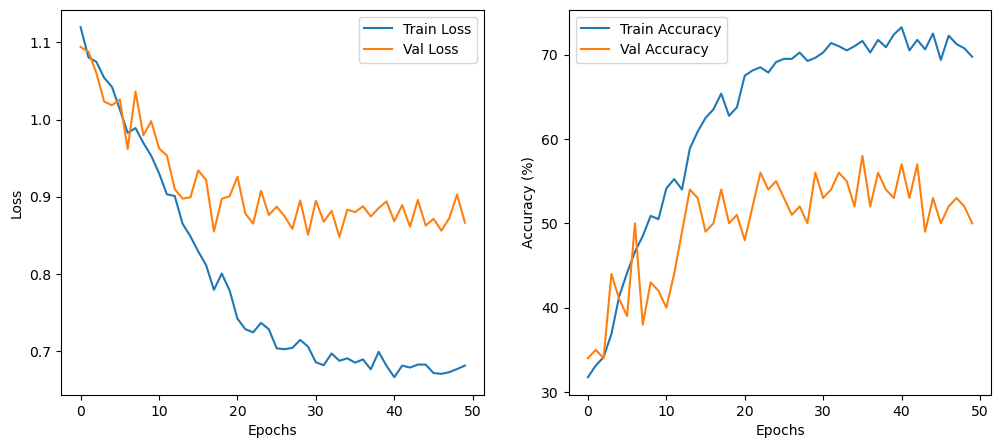

In [6]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
# -------------------------
# Set loss function and optimizer
# -------------------------
model = ShapeClassifierCNN()
class_weights = torch.tensor([1.5, 1.0, 1.0])  # Increase loss contribution from class 0 (circle)重
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Apply L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# -------------------------
# Train the model
# -------------------------
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early stopping parameters
best_val_acc = 0
patience = 15  # Number of epochs with no improvement before stopping
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Ensure labels are LongTensor
        labels = labels.long()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Ensure labels are LongTensor
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print training and validation results for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
    scheduler.step()

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

# -------------------------
# Plot training and validation loss and accuracy curves
# -------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curve
ax1.plot(range(len(train_losses)), train_losses, label='Train Loss')
ax1.plot(range(len(val_losses)), val_losses, label='Val Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy curve
ax2.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
ax2.plot(range(len(val_accuracies)), val_accuracies, label='Val Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()

Test Accuracy: 56.00%


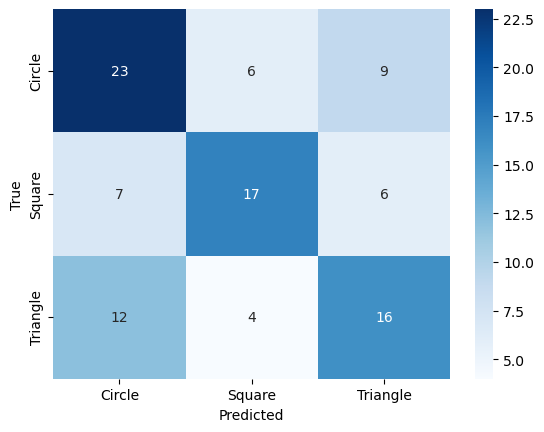

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Circle', 'Square', 'Triangle'], yticklabels=['Circle', 'Square', 'Triangle'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

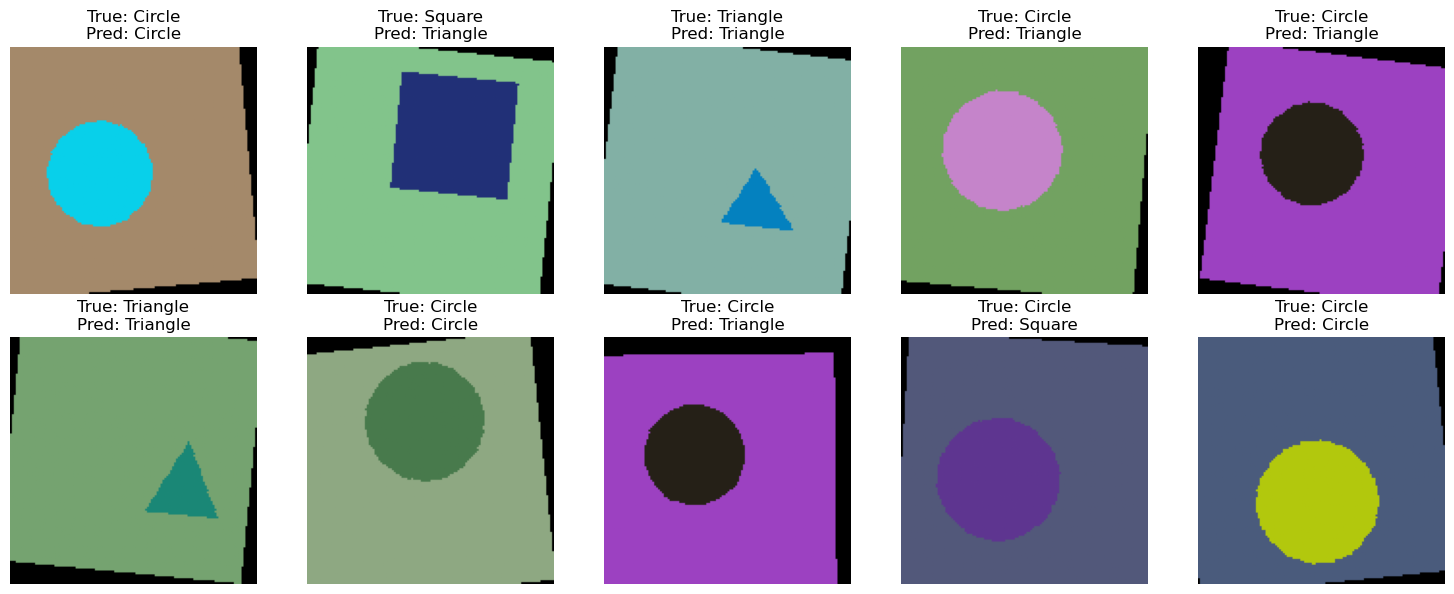

In [8]:
# Visualize predictions on test data
import random

model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
classes = ['Circle', 'Square', 'Triangle']

for ax in axes:
    idx = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[idx]
    image_input = image.unsqueeze(0)  # add batch dimension
    output = model(image_input)
    _, predicted = torch.max(output, 1)

    image_np = image.permute(1, 2, 0).numpy()  # convert to HWC
    image_np = (image_np * 0.5 + 0.5).clip(0, 1)  # unnormalize

    ax.imshow(image_np)
    ax.set_title(f"True: {classes[label]}\nPred: {classes[predicted.item()]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Conclusion:

### This project demonstrates how to generate synthetic shape data and train a CNN to classify images into three categories. The dataset includes four variation conditions to test model robustness. With a simple CNN and data augmentation, the model achieves high test accuracy. Possible improvements include increasing dataset size, using more advanced architectures like ResNet, or experimenting with shape detection under occlusion or noise.